![banner-image](assets/AD-SQUAD.png)

<a id='top'></a>
# Loan Default Prediction

#### Table of Content
<ul>
    <li><a href='#intro'>1.0 Introduction</a></li>
    <li><a href='#data'>2.0 Data Description</a></li>
    <li><a href='#explore'>3.0 Data Exploration</a></li>
    <li><a href='#merge'>4.0 Merging</a></li>
    <li><a href='#process'>5.0 Preprocessing</a></li>
    <li><a href='#engineer'>- Feature Engineering</a></li>
    <li><a href='#imbalance'>- Handling Imbalance</a></li>
    <li><a href='#prediction'>Predication</a></li>
    <li><a href='#results'>Results</a></li>
    <li><a href='#end'>End</a></li>
</ul>

<a id='intro'></a>

## 1.0 Introduction

##### 1.1 Problem Definition
Financial institutions need to determine whether a borrower is likely to default on a loan before disbursing funds. Accurately predicting loan default reduces financial risk, improves lending decisions, and supports sustainable portfolio growth.

In this project, the goal is to build a machine learning model that predicts whether a loan will be good (1) or bad (0) using customer demographics, previous loan histories, and performance data.

##### 1.2 Target Variable - good_bad_flag
* 1 = good loan (loan was repaid on time)
* 0 = bad loan (loan was not repaid on time)

<a id='data'></a>

## 2.0 Data Description

#### 2.1 Summary

This project consists of three training datasets and three corresponding test datasets. All datasets are linked using the primary key **customerid**.

**Dataset 1:** Demographic Data — traindemographics.csv

* Contains customer profile and background information.

**Dataset 2:** Performance Data — trainperf.csv

* Contains details about the loan we want to predict.
* This dataset provides the label we are predicting.

**Dataset 3:** Previous Loans Data — trainprevloans.csv

* Historical loans for each customer prior to the target loan.
* This helps capture customer risk profile based on past behavior.

#### 2.2 Why Multiple Datasets?
The loan outcome depends not only on the target loan details but also on the customer’s demographics and previous loan behaviour. Therefore, we need to merge these datasets on customerid to build a complete feature set.

In [1]:
# Importing Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load datasets

demo = pd.read_csv("data/test/testdemographics.csv")
perf = pd.read_csv("data/test/testperf.csv")
prev = pd.read_csv("data/test/testprevloans.csv")

In [3]:
demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858f305c8dd672015c93b1db645db4,1976-08-28 00:00:00.000000,Savings,5.296628,7.593965,Heritage Bank,NaN,Permanent,NaN
1,8a858f085a477386015a47fb049e49ca,1978-06-23 00:00:00.000000,Savings,3.294513,6.596602,UBA,NaN,Permanent,NaN
2,8a858e6f5cd5e874015cd6f5634c39ad,1984-04-04 00:00:00.000000,Savings,8.501912,7.729364,First Bank,NaN,Permanent,NaN
3,8a858e9d5bfd7037015bfdab79f61305,1983-05-28 00:00:00.000000,Savings,3.318904,6.681595,UBA,NaN,Permanent,NaN
4,8a858fde56eb02280156eb6dafc128ac,1982-03-29 00:00:00.000000,Savings,6.354624,4.949031,First Bank,NaN,Self-Employed,NaN


In [4]:
perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN


In [5]:
prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301621635,3,2016-05-17 10:37:00.000000,2016-05-17 09:36:55.000000,10000.0,13000.0,30,2016-06-17 00:04:15.000000,NaN,2016-06-16 00:00:00.000000,2016-06-16 15:44:08.000000
1,8a858959537a097401537a4e316e25f7,301810201,5,2017-02-04 21:28:59.000000,2017-02-04 20:28:52.000000,30000.0,36800.0,60,2017-03-02 16:22:58.000000,NaN,2017-03-06 00:00:00.000000,2017-03-02 16:07:47.000000
2,8a858959537a097401537a4e316e25f7,301831255,6,2017-03-04 10:28:22.000000,2017-03-04 09:28:16.000000,30000.0,34400.0,30,2017-04-02 00:44:24.000000,NaN,2017-04-03 00:00:00.000000,2017-04-01 21:29:46.000000
3,8a8589c253ace09b0153af6ba58f1f31,301627292,3,2016-06-02 14:27:14.000000,2016-06-02 13:27:08.000000,10000.0,13000.0,30,2016-07-04 11:34:04.000000,NaN,2016-07-04 00:00:00.000000,2016-07-04 11:19:01.000000
4,8a8589c253ace09b0153af6ba58f1f31,301621095,2,2016-05-16 09:13:12.000000,2016-05-16 08:13:04.000000,10000.0,11500.0,15,2016-06-02 00:02:58.000000,NaN,2016-05-31 00:00:00.000000,2016-06-01 15:22:34.000000


<a id='explore'></a>

## 3.0 Data Exploration

#### 3.1. Inspecting data - _checking shape for demo, pref and prev datasets_

#### 3.2. Checking & Handling Duplicates - _checking & handling duplicate values in customer id in demo and pref_

#### 3.3. Checking & Handling Missing Data - _checking & handling missing values in each dataset_

In [6]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  1487 non-null   object 
 1   birthdate                   1487 non-null   object 
 2   bank_account_type           1487 non-null   object 
 3   longitude_gps               1487 non-null   float64
 4   latitude_gps                1487 non-null   float64
 5   bank_name_clients           1487 non-null   object 
 6   bank_branch_clients         14 non-null     object 
 7   employment_status_clients   1270 non-null   object 
 8   level_of_education_clients  210 non-null    object 
dtypes: float64(2), object(7)
memory usage: 104.7+ KB


In [7]:
perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customerid    1450 non-null   object 
 1   systemloanid  1450 non-null   int64  
 2   loannumber    1450 non-null   int64  
 3   approveddate  1450 non-null   object 
 4   creationdate  1450 non-null   object 
 5   loanamount    1450 non-null   int64  
 6   totaldue      1450 non-null   float64
 7   termdays      1450 non-null   int64  
 8   referredby    184 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 102.1+ KB


In [8]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5907 entries, 0 to 5906
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       5907 non-null   object 
 1   systemloanid     5907 non-null   int64  
 2   loannumber       5907 non-null   int64  
 3   approveddate     5907 non-null   object 
 4   creationdate     5907 non-null   object 
 5   loanamount       5907 non-null   float64
 6   totaldue         5907 non-null   float64
 7   termdays         5907 non-null   int64  
 8   closeddate       5907 non-null   object 
 9   referredby       325 non-null    object 
 10  firstduedate     5907 non-null   object 
 11  firstrepaiddate  5907 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 553.9+ KB


In [9]:
print("Demographics:", demo.shape)
print("Performance:", perf.shape)
print("Previous Loans:", prev.shape)

Demographics: (1487, 9)
Performance: (1450, 9)
Previous Loans: (5907, 12)


In [10]:
print("Demographics:", demo.dtypes.value_counts())
print("Performance:", perf.dtypes.value_counts())
print("Previous Loans:", prev.dtypes.value_counts())

Demographics: object     7
float64    2
Name: count, dtype: int64
Performance: object     4
int64      4
float64    1
Name: count, dtype: int64
Previous Loans: object     7
int64      3
float64    2
Name: count, dtype: int64


describe the dataset 1 by 1.

In [11]:
#demo.describe()
perf.describe()

,systemloanid,loannumber,loanamount,totaldue,termdays
count,1.450000e+03,1450.000000,1450.000000,1450.000000,1450.000000
mean,3.019807e+08,5.088966,17482.758621,20874.664069,28.810345
std,1.339572e+04,3.665210,10585.420034,11726.584630,11.074839
min,3.019585e+08,2.000000,10000.000000,10500.000000,15.000000
25%,3.019687e+08,2.000000,10000.000000,13000.000000,30.000000
50%,3.019799e+08,4.000000,10000.000000,13000.000000,30.000000
75%,3.019929e+08,7.000000,20000.000000,24500.000000,30.000000
max,3.020040e+08,34.000000,60000.000000,68100.000000,90.000000


#### 3.2.1 Check for Duplicates

In [12]:
print("Demographics:", demo.duplicated("customerid").sum())
print("Performance:", perf.duplicated(["customerid", "systemloanid"]).sum())
print("Previous Loans:", prev.duplicated(["customerid", "systemloanid"]).sum())

Demographics: 3
Performance: 0
Previous Loans: 0


##### 3.2.2 Handling Duplicates in Demo Data

In [13]:
dupes = demo[demo.duplicated(subset="customerid", keep=False)]
dupes

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
248,8a858e885b68546c015b7238f22027ba,1975-06-18 00:00:00.000000,Savings,3.353123,6.587837,First Bank,NaN,Permanent,NaN
497,8a8588b75438f49901544510041e0951,1980-01-16 00:00:00.000000,Other,3.342808,6.542411,Zenith Bank,NaN,Permanent,Graduate
502,8a8588b75438f49901544510041e0951,1980-01-16 00:00:00.000000,Other,3.342808,6.542411,Zenith Bank,NaN,Permanent,Graduate
810,8a858e885b68546c015b7238f22027ba,1975-06-18 00:00:00.000000,Savings,3.353123,6.587837,First Bank,NaN,Permanent,NaN
1252,8a858f2e5c699f3a015c6e10b65607c9,1978-06-20 00:00:00.000000,Savings,3.325513,6.500937,GT Bank,NaN,Permanent,NaN
1285,8a858f2e5c699f3a015c6e10b65607c9,1978-06-20 00:00:00.000000,Savings,3.325513,6.500937,GT Bank,NaN,Permanent,NaN


In [14]:
# Drop Duplicate Data

demo = demo.drop_duplicates(subset="customerid", keep="first")

#### 3.3.1 Identify Missing Values Early

In [15]:
print("Demographics:", demo.isnull().sum())

Demographics: customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           1470
employment_status_clients      217
level_of_education_clients    1275
dtype: int64


In [16]:
print("Performance:", perf.isnull().sum())

Performance: customerid         0
systemloanid       0
loannumber         0
approveddate       0
creationdate       0
loanamount         0
totaldue           0
termdays           0
referredby      1266
dtype: int64


In [17]:
print("Previous Loans:", prev.isnull().sum())

Previous Loans: customerid            0
systemloanid          0
loannumber            0
approveddate          0
creationdate          0
loanamount            0
totaldue              0
termdays              0
closeddate            0
referredby         5582
firstduedate          0
firstrepaiddate       0
dtype: int64


#### 3.3.2 Handling Missing Values

* Demographics Dataset:
Bank Branch, Education Level and Employment Status are usually optional fields in a loan application. These categorical fields missing values will be filled with "Unknown".

* Performance Dataset:
Referral field was most likely an optional field. Since this values where were missing due to a lack of information intentionally provided during loan application process, Missing Value Imputation Stategy will be to simply replace missing values with "Unknown"

* Previous Loans Dataset:
Referral field was most likely an optional field. Since this values where were missing due to a lack of information intentionally provided during loan application process, Missing Value Imputation Stategy will be to simply replace missing values with "Unknown"

In [18]:
demo["bank_branch_clients"].fillna("Unknown", inplace=True)
demo["employment_status_clients"].fillna("Unknown", inplace=True)
demo["level_of_education_clients"].fillna("Unknown", inplace=True)

print("Demographics:", demo.isnull().sum())

Demographics: customerid                    0
birthdate                     0
bank_account_type             0
longitude_gps                 0
latitude_gps                  0
bank_name_clients             0
bank_branch_clients           0
employment_status_clients     0
level_of_education_clients    0
dtype: int64


In [19]:
perf["referredby"].fillna("Unknown", inplace=True)

print("Performance:", perf.isnull().sum())

Performance: customerid      0
systemloanid    0
loannumber      0
approveddate    0
creationdate    0
loanamount      0
totaldue        0
termdays        0
referredby      0
dtype: int64


In [20]:
prev["referredby"].fillna("Unknown", inplace=True)

print("Previous Loans:", prev.isnull().sum())

Previous Loans: customerid         0
systemloanid       0
loannumber         0
approveddate       0
creationdate       0
loanamount         0
totaldue           0
termdays           0
closeddate         0
referredby         0
firstduedate       0
firstrepaiddate    0
dtype: int64


In [21]:
print("Remaining missing values in demographics:", demo.isnull().sum().sum())
print("Remaining missing values in performance:", perf.isnull().sum().sum())
print("Remaining missing values in previous loans:", prev.isnull().sum().sum())

Remaining missing values in demographics: 0
Remaining missing values in performance: 0
Remaining missing values in previous loans: 0


<a id='merge'></a>

## 4.0 Merge data

**Objective:** We need to merge all 3 datasets.

* Performance (trainpref) is the MAIN dataset since it contains the TARGET (good_bad_flag). 

**Note:** *Since Previous Loan Dataset can contain multiple previous loans for each customer, meaning the data here will have a 1-to-many format. To keep this dataset in a 1 row per customer format, we must summarize(aggregate) the previous loans dataset (1-to-1 format)*

* Step 1: Merge Performace and Demographics
* Step 2: Prepare Previous Loans Dataset
* Step 3: Aggregated Previous Loan History per Customer
* Step 4: Merge Aggregate to (Performance and Demographics) dataframe

#### 4.1 Merge Performace and Demographics

In [22]:
# STEP 1: PERFORMANCE + DEMOGRAPHICS

df = perf.merge(demo, on="customerid", how="left")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  1450 non-null   object 
 1   systemloanid                1450 non-null   int64  
 2   loannumber                  1450 non-null   int64  
 3   approveddate                1450 non-null   object 
 4   creationdate                1450 non-null   object 
 5   loanamount                  1450 non-null   int64  
 6   totaldue                    1450 non-null   float64
 7   termdays                    1450 non-null   int64  
 8   referredby                  1450 non-null   object 
 9   birthdate                   385 non-null    object 
 10  bank_account_type           385 non-null    object 
 11  longitude_gps               385 non-null    float64
 12  latitude_gps                385 non-null    float64
 13  bank_name_clients           385 n

#### 4.2 Prepare Previous Loans Dataset

In [23]:
# Converting date columns to Datetime Dtye

prev['approveddate'] = pd.to_datetime(prev['approveddate'])
prev['creationdate'] = pd.to_datetime(prev['creationdate'])
prev['closeddate'] = pd.to_datetime(prev['closeddate'])
prev['firstduedate'] = pd.to_datetime(prev['firstduedate'])
prev['firstrepaiddate'] = pd.to_datetime(prev['firstrepaiddate'])

In [24]:
# New column: repayment delay = firstrepaiddate - firstduedate

prev['repayment_delay'] = (prev['firstrepaiddate'] - prev['firstduedate']).dt.days

#### 4.3 Aggregated Previous Loan History per Customer

In [25]:
# STEP 3: AGGREGATED PREVIOUS LOAN HISTORY PER CUSTOMER

agg_prev = prev.groupby("customerid").agg({
    "systemloanid": "count",
    "loanamount": ["mean", "max"],
    "totaldue": ["mean"],
    "termdays": ["mean", "max"],
    "repayment_delay": ["mean"],
})

agg_prev.columns = ["_".join(col) for col in agg_prev.columns]
agg_prev.head()

,systemloanid_count,loanamount_mean,loanamount_max,totaldue_mean,termdays_mean,termdays_max,repayment_delay_mean
customerid,,,,,,,
8a28afc7474813a40147639ec637156b,10,17800.000000,30000.0,21090.000000,31.5,60,-3.300000
8a3735d5518aba7301518ac34413010d,6,11666.666667,20000.0,14666.666667,27.5,30,-12.666667
8a76e7d443e6e97c0143ed099d102b1d,2,10000.000000,10000.0,11500.000000,15.0,15,-2.000000
8a818823525dceef01525deda2480384,9,18888.888889,40000.0,23330.555556,40.0,60,0.111111
8a818926522ea5ef01523aff15c37482,2,10000.000000,10000.0,13000.000000,30.0,30,8.500000


#### 4.4 Merge Aggregate to (Performance and Demographics) dataframe

In [26]:
# STEP 4: MERGE AGGREGATE PREVIOUS-LOANS STATISTICS TO (PERFORMANCE + DEMOGRAPHICS) DATAFRAME

df = df.merge(agg_prev, on="customerid", how="left")

df.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,birthdate,...,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid_count,loanamount_mean,loanamount_max,totaldue_mean,termdays_mean,termdays_max,repayment_delay_mean
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,Unknown,NaN,...,NaN,NaN,NaN,3.0,8666.666667,10000.0,10966.666667,25.000000,30.0,3.333333
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,Unknown,NaN,...,NaN,NaN,NaN,9.0,23888.888889,40000.0,27600.000000,31.666667,60.0,-3.888889
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,Unknown,1981-09-05 00:00:00.000000,...,Unknown,Permanent,Unknown,5.0,13000.000000,20000.0,15935.000000,27.000000,30.0,3.600000
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,Unknown,NaN,...,NaN,NaN,NaN,7.0,17142.857143,30000.0,19342.857143,17.142857,30.0,-3.285714
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,Unknown,1975-08-25 00:00:00.000000,...,Unknown,Permanent,Unknown,3.0,10000.000000,10000.0,12500.000000,25.000000,30.0,-3.333333


*Now we have our fully merged dataset and we can prepare it for training*

In [27]:
# SAVE MERGED CSV (BEFORE PREPROCESSING)

<a id='process'></a>

## 5.0 Data Preprocessing

* Step 1: Handling Missing Values
* Step 2: Cross-Checking for Duplicate
* Step 3: Encoding Categoricals
* Step 4: Feature Engineering
* Step 5: Outleirs
* Step 6: Handling Data Imbalance


#### 5.1 Handling Missing Values

In [28]:
df.isna().sum()

customerid                       0
systemloanid                     0
loannumber                       0
approveddate                     0
creationdate                     0
loanamount                       0
totaldue                         0
termdays                         0
referredby                       0
birthdate                     1065
bank_account_type             1065
longitude_gps                 1065
latitude_gps                  1065
bank_name_clients             1065
bank_branch_clients           1065
employment_status_clients     1065
level_of_education_clients    1065
systemloanid_count               8
loanamount_mean                  8
loanamount_max                   8
totaldue_mean                    8
termdays_mean                    8
termdays_max                     8
repayment_delay_mean             8
dtype: int64

From here you can see there are 2 types of missing values.

1. Missing demographics data which will be imputed with "Unknown"
2. Missing previous-loan aggregated metrics (9 missing)

In [29]:
demo_cols = [
    'bank_account_type', 'longitude_gps', 'latitude_gps',
    'bank_name_clients', 'bank_branch_clients', 'employment_status_clients',
    'level_of_education_clients'
]

for col in demo_cols:
    df[col] = df[col].fillna("Unknown")

In [30]:
# impute birthday with 1900-01-01 and also create a new column to flag it as missing or not.

df["birthdate"] = df["birthdate"].fillna(pd.Timestamp("1900-01-01"))

If a customers aggregated values are missing then they do not have previous loans. Hence we impute with 0.

In [31]:
df['systemloanid_count'] = df['systemloanid_count'].fillna(0)

In [32]:
num_cols = [
    'loanamount_mean', 'loanamount_max', 'totaldue_mean',
    'termdays_mean', 'termdays_max', 'repayment_delay_mean'
]

for col in num_cols:
    df[col] = df[col].fillna(0)

In [33]:
df.isna().sum()

customerid                    0
systemloanid                  0
loannumber                    0
approveddate                  0
creationdate                  0
loanamount                    0
totaldue                      0
termdays                      0
referredby                    0
birthdate                     0
bank_account_type             0
longitude_gps                 0
latitude_gps                  0
bank_name_clients             0
bank_branch_clients           0
employment_status_clients     0
level_of_education_clients    0
systemloanid_count            0
loanamount_mean               0
loanamount_max                0
totaldue_mean                 0
termdays_mean                 0
termdays_max                  0
repayment_delay_mean          0
dtype: int64

#### 5.2 Handling for Duplicates

#### 5.3 Encoding Categoricals

In [34]:
cat_cols = ["bank_account_type", "bank_name_clients","bank_branch_clients", "employment_status_clients",
            "level_of_education_clients"]

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [35]:
# Compare before and after

#df_encoded.shape

In [36]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 82 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   customerid                                                                          4368 non-null   object 
 1   systemloanid                                                                        4368 non-null   int64  
 2   loannumber                                                                          4368 non-null   int64  
 3   approveddate                                                                        4368 non-null   object 
 4   creationdate                                                                        4368 non-null   object 
 5   loanamount                                                                          4368 non-null

In [37]:
# ENCODING 

df_encoded["good_bad_flag"] = df_encoded["good_bad_flag"].map({"Good": 0, "Bad": 1})

#### 5.4 Feature Engineering

In [38]:
# DROP IDENTIFIERS and NON CRITICAL Data

df_encoded = df_encoded.drop(columns=["customerid", "systemloanid","referredby","longitude_gps","latitude_gps"])

In [39]:
# LOAN CREATION => APPROVAL DELAY
# This shows how long it took to approve the loan. Could indicate speed of processing for cerain customers

df_encoded["creationdate"] = pd.to_datetime(df_encoded["creationdate"])
df_encoded["approveddate"] = pd.to_datetime(df_encoded["approveddate"])

df_encoded["loan_creation_to_approval_days"] = (df_encoded["approveddate"] - df_encoded["creationdate"]).dt.days

In [40]:
# AGE IS OFTEN PREDICTIVE
df_encoded["birthdate"] = pd.to_datetime(df_encoded["birthdate"])

df_encoded["customer_age"] = (pd.to_datetime("today") - df_encoded["birthdate"]).dt.days // 365

In [41]:
# DROP ORIGINAL DATES

df_encoded = df_encoded.drop(columns=["approveddate","creationdate","birthdate"])

In [42]:
#NUMERIC TRANSFORMATIONS
#Loan ratio: How much is the total due compared to the original loan amount

#df["totaldue_to_loanamount_ratio"] = df["totaldue"] / df["loanamount"]

In [43]:
#Loan term in months: Easier to interpret than days

#df["termdays_months"] = df["termdays"] / 30

#### 5.5 Handling Outliers

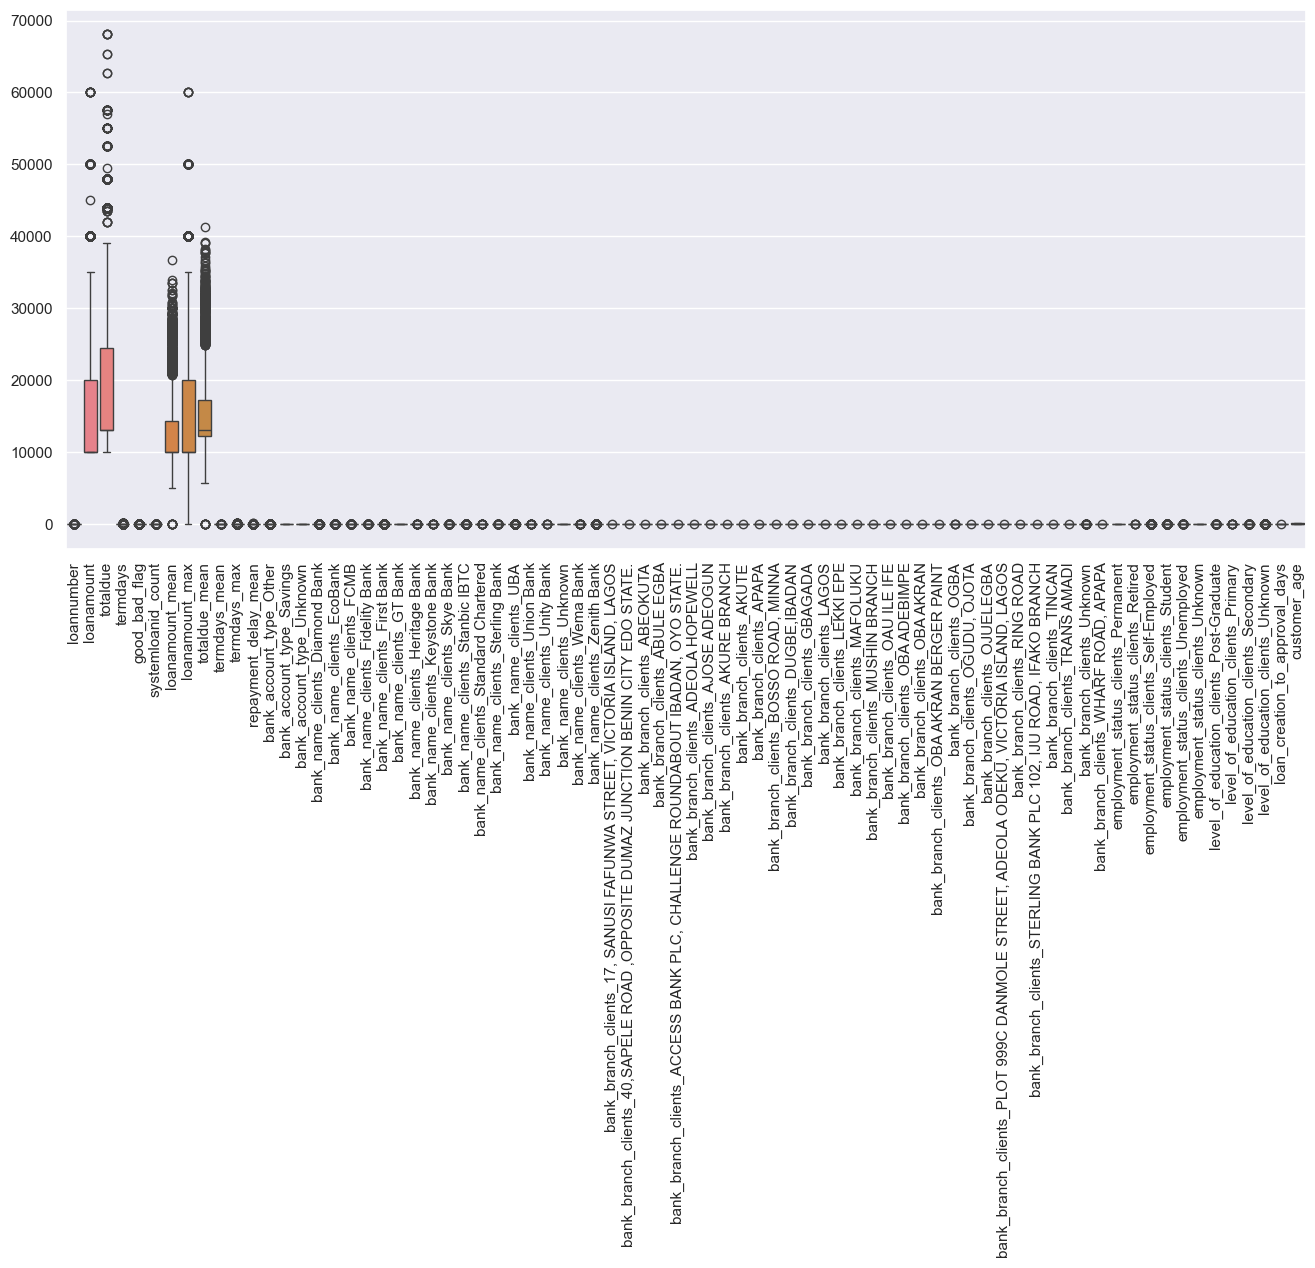

In [ ]:
sns.set_theme(style='darkgrid', palette='muted')
fig, ax = plt.subplots(figsize=(16,7))
sns.boxplot(data=df_encoded)
plt.xticks(rotation=90);

#### 5.6 Handling Data Imbalance

In [44]:
X = df_encoded.drop("good_bad_flag", axis=1)
y = df_encoded["good_bad_flag"]

In [45]:
proportions = y.value_counts(normalize=True)

print("Class Distribution:")
print(f"Good (0): {proportions[0]:.4f}")
print(f"Bad  (1): {proportions[1]:.4f}")

Class Distribution:
Good (0): 0.7821
Bad  (1): 0.2179


#### Visualize Data Imbalance - Good vs Bad

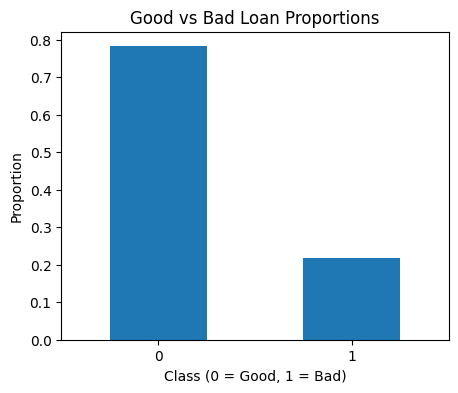

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
proportions.plot(kind='bar')

plt.title("Good vs Bad Loan Proportions")
plt.xlabel("Class (0 = Good, 1 = Bad)")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

#### Handling Data Imbalance with Borderline Smote

In [47]:
from imblearn.over_sampling import BorderlineSMOTE

# Apply Borderline-SMOTE
sm = BorderlineSMOTE(kind="borderline-1", random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("After Borderline-SMOTE:")
print(y_res.value_counts(normalize=True))

After Borderline-SMOTE:
good_bad_flag
0    0.5
1    0.5
Name: proportion, dtype: float64


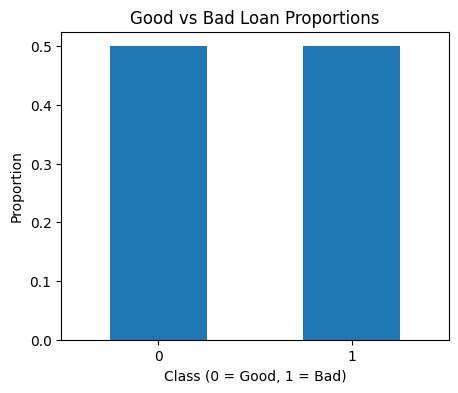

In [49]:
proportions_after = y_res.value_counts(normalize=True)
plt.figure(figsize=(5,4))
proportions_after.plot(kind='bar')
plt.title("Good vs Bad Loan Proportions")
plt.xlabel("Class (0 = Good, 1 = Bad)")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

## Feature Exploration
corr heatmap, initial importance

In [50]:
### THIS IS THE SAME AS EDA AND NEEDS TO BE DONE BEFORE PREPROCESSING.

## Training

* STEP 1: Split data into training and validation sets
* STEP 2: Select Models. We Select 3 models of different families
* STEP 3: Training Each Model

##### Splitting Data into Training and Validation Sets

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

Model Selection. We are using
Since you want 3 different models, a common strategy is to cover different families:
Traditional / baseline model → e.g., Logistic Regression

Simple, interpretable, a good baseline to compare against.

Tree-based model → e.g., Decision Tree or Random Forest

Handles non-linear relationships, doesn’t need feature scaling, gives feature importance.

Boosting model → e.g., XGBoost / LightGBM / CatBoost

Often the best predictive performance, handles imbalance well, captures complex interactions.
1. Logistic Regression
2. Random Forest
3. XGBoost

##### MODEL 1: LOGISTIC REGRESSION

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Logistic Regression Pipeline
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=500))
])

# Train
log_reg.fit(X_train, y_train)

# Predict
y_pred_lr = log_reg.predict(X_val)
y_proba_lr = log_reg.predict_proba(X_val)[:, 1]

# Evaluation
print("=== Logistic Regression Results ===")
print(classification_report(y_val, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_val, y_proba_lr))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

=== Logistic Regression Results ===
              precision    recall  f1-score   support

           0       0.74      0.88      0.81       684
           1       0.85      0.69      0.77       683

    accuracy                           0.79      1367
   macro avg       0.80      0.79      0.79      1367
weighted avg       0.80      0.79      0.79      1367

ROC-AUC Score: 0.8677756800493182

Confusion Matrix:
[[602  82]
 [209 474]]


MODEL 2: RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_val)
y_proba_rf = rf.predict_proba(X_val)[:, 1]

# Evaluation
print("=== Random Forest Results ===")
print(classification_report(y_val, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_val, y_proba_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_rf))

=== Random Forest Results ===
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       684
           1       0.86      0.81      0.83       683

    accuracy                           0.84      1367
   macro avg       0.84      0.84      0.84      1367
weighted avg       0.84      0.84      0.84      1367

ROC-AUC Score: 0.9056964030378533

Confusion Matrix:
[[594  90]
 [132 551]]


##### XGBOOST CLASSIFIER

In [54]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss"
)

# Train
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_val)
y_proba_xgb = xgb.predict_proba(X_val)[:, 1]

# Evaluation
print("=== XGBoost Results ===")
print(classification_report(y_val, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_val, y_proba_xgb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))


=== XGBoost Results ===
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       684
           1       0.86      0.73      0.79       683

    accuracy                           0.81      1367
   macro avg       0.82      0.81      0.81      1367
weighted avg       0.82      0.81      0.81      1367

ROC-AUC Score: 0.8890012671992327

Confusion Matrix:
[[606  78]
 [185 498]]


<a id='results'></a>

## EVALUATION & COMPARISON
1. EVALUATE PERFORMANCE using Metrics : Accuracy, Precision, Recall, F1-score, ROC-AUC and confusion matrix
2. FEATURE IMPORTANCE
3. COMPARE MODELS Goal: Decide which model performs best for our specific goal
and Justify choice using metics.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# List of models and their predictions
models = ["Logistic Regression", "Random Forest", "XGBoost"]
preds = [y_pred_lr, y_pred_rf, y_pred_xgb]      # predicted labels
probas = [y_proba_lr, y_proba_rf, y_proba_xgb]  # predicted probabilities

# Create an empty list to store results
results = []

# Loop over models to calculate metrics
for i, model in enumerate(models):
    y_pred = preds[i]
    y_proba = probas[i]
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    
    # Classification report
    report = classification_report(y_val, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    # Accuracy & ROC-AUC
    acc = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    results.append({
        "Model": model,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Accuracy": acc,
        "ROC-AUC": roc_auc,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display nicely
results_df


,Model,Precision,Recall,F1-score,Accuracy,ROC-AUC,TP,TN,FP,FN
0,Logistic Regression,0.797365,0.787125,0.785257,0.787125,0.867776,474,602,82,209
1,Random Forest,0.838873,0.837601,0.837443,0.837601,0.905696,551,594,90,132
2,XGBoost,0.815315,0.807608,0.806411,0.807608,0.889001,498,606,78,185


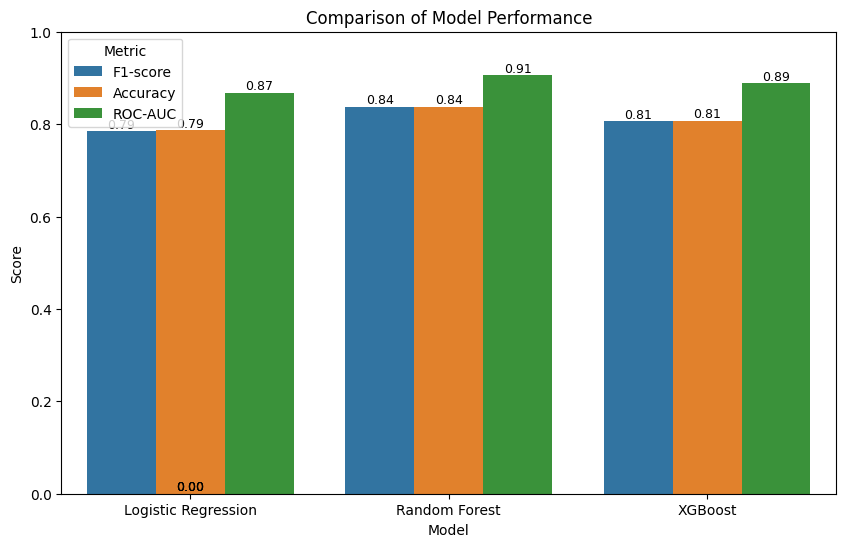

In [60]:
# Select the metrics you want to plot
metrics = ['F1-score', 'Accuracy', 'ROC-AUC']

# Prepare data for plotting
plot_df = results_df.melt(id_vars='Model', value_vars=metrics,
                          var_name='Metric', value_name='Score')

# Create grouped bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=plot_df, x='Model', y='Score', hue='Metric')

# Add title and labels
plt.title('Comparison of Model Performance')
plt.ylim(0, 1)  # since all metrics are between 0 and 1
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')

# Annotate bars with actual values
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height:.2f}', 
                       (p.get_x() + p.get_width() / 2., height), 
                       ha='center', va='bottom', fontsize=9)

plt.show()

##### Conclusion

As shown in the diagram

<a id='model'></a>

## Saving Final Model
Saving model trained model.

<a id='end'></a> 

## Thank You

<li><a href='#top'>Back to top</a></li>